# Time Series prediciton with LSTM

In [6]:
import sys
#pandas==1.2.3
!{sys.executable} -m pip install install xlrd==1.2.0

     ---------------------------------------- 9.3/9.3 MB 7.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\abisade\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\~andas\\_libs\\algos.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'C:\Users\abisade\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


## Library definitions

defining the libraries necessary for defining, training and testing the model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil import parser
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import os.path
from datetime import datetime as dt

from dataRip import scrape_hourly_candles

## Scrape hourly data

if the data is not already available, the data is scraped from the website (binance) using the function defined in the dataRip.py file. This function returns an excel file with the data. If the data is already available, the function skips the scraping process.

In [17]:

TRADE_PAIR = "LTCUSDT"
START_DATE = startingDate=dt(2018,5,5)

print(os.path.isfile(f"./data/{TRADE_PAIR}.xlsx"))

if not os.path.isfile(f"./data/{TRADE_PAIR}.xlsx"):
    scrape_hourly_candles(TRADE_PAIR, START_DATE)

False
saved 25rows of data
saved 49rows of data
saved 73rows of data
saved 97rows of data
saved 121rows of data
saved 145rows of data
saved 169rows of data
saved 193rows of data
saved 217rows of data
saved 241rows of data
saved 265rows of data
saved 289rows of data
saved 313rows of data
saved 337rows of data
saved 361rows of data
saved 385rows of data
saved 409rows of data
saved 433rows of data
saved 457rows of data
saved 481rows of data
saved 505rows of data
saved 529rows of data
saved 553rows of data
saved 577rows of data
saved 601rows of data
saved 625rows of data
saved 649rows of data
saved 673rows of data
saved 697rows of data
saved 721rows of data
saved 745rows of data
saved 769rows of data
saved 793rows of data
saved 817rows of data
saved 841rows of data
saved 865rows of data
saved 889rows of data
saved 913rows of data
saved 937rows of data
saved 961rows of data
saved 985rows of data
saved 1009rows of data
saved 1033rows of data
saved 1057rows of data
saved 1081rows of data
save

## data load

opens the excel file with the data and loads the data into a dataframe. Pandas is used for this. After the data is loaded, it is output.

In [18]:
training_set = pd.read_excel(f"data/{TRADE_PAIR}.xlsx",engine='openpyxl')

training_set.drop(0)
ts = pd.DataFrame(training_set).iloc[:,:]


print(ts)

                Unnamed: 0     Unnamed: 1  Unnamed: 2  Unnamed: 3  Unnamed: 4  \
0      2018-05-06 00:00:00  1525568400000      181.89      183.08      180.80   
1      2018-05-06 01:00:00  1525572000000      182.42      182.46      179.07   
2      2018-05-06 02:00:00  1525575600000      179.63      181.68      179.26   
3      2018-05-06 03:00:00  1525579200000      179.82      181.50      179.82   
4      2018-05-06 04:00:00  1525582800000      180.21      180.49      174.50   
...                    ...            ...         ...         ...         ...   
34411  2022-05-02 19:00:00  1651521600000      100.70      100.70      100.00   
34412  2022-05-02 20:00:00  1651525200000      100.10      101.30      100.00   
34413  2022-05-02 21:00:00  1651528800000      101.30      101.90      100.80   
34414  2022-05-02 22:00:00  1651532400000      100.90      101.30      100.40   
34415  2022-05-02 23:00:00  1651536000000      100.70      100.90      100.20   

       Unnamed: 5  
0      

## Data loading

defines the test split function, splitting the data into training and testing sets. The test size is 7% of the original data size. The function returns the training and testing dataframes.

In [22]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(ts, test_size=0.07)

print(train)

                Unnamed: 0     Unnamed: 1  Unnamed: 2  Unnamed: 3  Unnamed: 4  \
0      2018-05-06 00:00:00  1525568400000      181.89      183.08      180.80   
1      2018-05-06 01:00:00  1525572000000      182.42      182.46      179.07   
2      2018-05-06 02:00:00  1525575600000      179.63      181.68      179.26   
3      2018-05-06 03:00:00  1525579200000      179.82      181.50      179.82   
4      2018-05-06 04:00:00  1525582800000      180.21      180.49      174.50   
...                    ...            ...         ...         ...         ...   
32002  2022-01-22 10:00:00  1642849200000      105.70      106.90      102.80   
32003  2022-01-22 11:00:00  1642852800000      105.60      109.30      105.40   
32004  2022-01-22 12:00:00  1642856400000      108.80      110.00      107.70   
32005  2022-01-22 13:00:00  1642860000000      108.80      109.50      106.30   
32006  2022-01-22 14:00:00  1642863600000      106.40      107.30      104.80   

       Unnamed: 5  
0      

## Visualization of train/test data

showing the training and testing data split for the report.

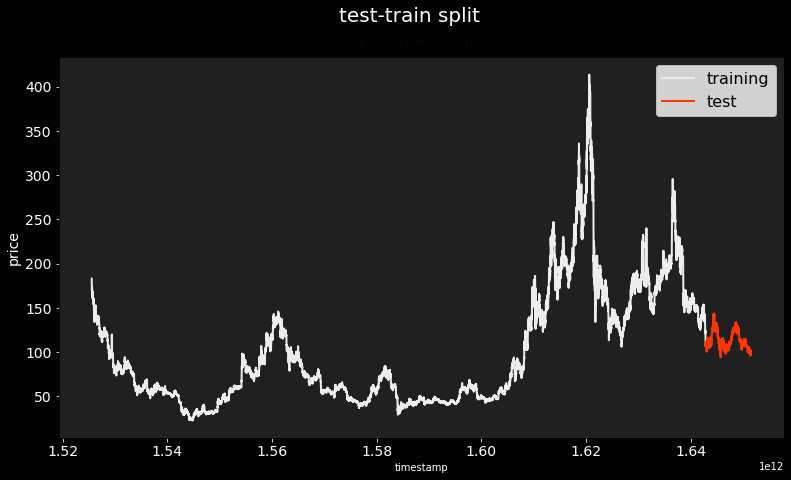

In [24]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7), facecolor='#030303')
    ax.plot(*zip(*line1), label=label1, c='#ededed', linewidth=lw)
    ax.plot(*zip(*line2), label=label2, c='#fc3503', linewidth=lw)
    plt.xlabel('timestamp', color='white')
    plt.ylabel('price', color='white')
    ax.set_facecolor('#202020')
    ax.tick_params(colors='white', labelsize=14)
    ax.set_ylabel('price', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    plt.suptitle(title, color='white', fontsize=20)

train_show =[[itm[0],float(itm[2])] for itm in train.iloc[:,:].values.tolist()]
test_show =[[itm[0],float(itm[2])] for itm in test.iloc[:,:].values.tolist()]
# train_show =[[parser.parse(itm[0]),float(itm[2])] for itm in train.iloc[:,:].values.tolist()]
# test_show =[[parser.parse(itm[0]),float(itm[2])] for itm in test.iloc[:,:].values.tolist()]
train = train.iloc[:,1:]
test = test.iloc[:,1:]
line_plot(train_show, test_show, 'training', 'test', title='test-train split')

## splitting data further into minibatches, for more effective training

using minmax scaling to normalize the data. The function returns the training and testing dataframes after being batched.

In [25]:
def minibatches(data, seqlen):
    x = []
    y = []

    for i in range(len(data)-seqlen-1):
        _x = data[i:(i+seqlen)]
        _y = data[i+seqlen]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training = sc.fit_transform(ts.iloc[:,1:].values)

seqlen = 5
x, y = minibatches(training, seqlen)

train_size = int(len(y) * 0.93)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print(trainX)
print(len(trainY))

tensor([[[0.0000e+00, 4.1114e-01, 4.1013e-01, 4.1653e-01, 4.1251e-01],
         [2.8579e-05, 4.1251e-01, 4.0854e-01, 4.1198e-01, 4.0528e-01],
         [5.7158e-05, 4.0531e-01, 4.0654e-01, 4.1248e-01, 4.0624e-01],
         [8.5736e-05, 4.0580e-01, 4.0608e-01, 4.1395e-01, 4.0742e-01],
         [1.1432e-04, 4.0680e-01, 4.0350e-01, 3.9997e-01, 3.9203e-01]],

        [[2.8579e-05, 4.1251e-01, 4.0854e-01, 4.1198e-01, 4.0528e-01],
         [5.7158e-05, 4.0531e-01, 4.0654e-01, 4.1248e-01, 4.0624e-01],
         [8.5736e-05, 4.0580e-01, 4.0608e-01, 4.1395e-01, 4.0742e-01],
         [1.1432e-04, 4.0680e-01, 4.0350e-01, 3.9997e-01, 3.9203e-01],
         [1.4289e-04, 3.9267e-01, 3.8880e-01, 3.8486e-01, 3.8862e-01]],

        [[5.7158e-05, 4.0531e-01, 4.0654e-01, 4.1248e-01, 4.0624e-01],
         [8.5736e-05, 4.0580e-01, 4.0608e-01, 4.1395e-01, 4.0742e-01],
         [1.1432e-04, 4.0680e-01, 4.0350e-01, 3.9997e-01, 3.9203e-01],
         [1.4289e-04, 3.9267e-01, 3.8880e-01, 3.8486e-01, 3.8862e-01],
  

## model

the definition of the LSTM model. Utilising pytorches LSTM model, with the final layer being a linear layer. The model is defined as batch_first = True, which means that the input is a batch of sequences.

In [26]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seqlen = seqlen
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))  
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        #output, (h_n, c_n)
        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## training

The hyperparameters are defined, the model is trained. The training is done in batches of 5, with a learning rate of 0.01. The model is saved after each epoch.

In [27]:
num_epochs = 2000
learning_rate = 0.01

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

loss_func = torch.nn.MSELoss() # mean-squared error
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) # Adaptive moment estimation

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss = loss_func(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.30420
Epoch: 100, loss: 0.03155
Epoch: 200, loss: 0.00877
Epoch: 300, loss: 0.00462
Epoch: 400, loss: 0.00156
Epoch: 500, loss: 0.00057
Epoch: 600, loss: 0.00025
Epoch: 700, loss: 0.00012
Epoch: 800, loss: 0.00007
Epoch: 900, loss: 0.00005
Epoch: 1000, loss: 0.00004
Epoch: 1100, loss: 0.00003
Epoch: 1200, loss: 0.00003
Epoch: 1300, loss: 0.00003
Epoch: 1400, loss: 0.00002
Epoch: 1500, loss: 0.00002
Epoch: 1600, loss: 0.00002
Epoch: 1700, loss: 0.00002
Epoch: 1800, loss: 0.00002
Epoch: 1900, loss: 0.00002


## testing

accuracy is calculated for the model. The model is tested on the test data.

In [28]:
def accuracy(y_hat, y):
    correct = 0
    total = len(y)
    """Compute the number of correct predictions."""
    for _, (yhat_i, y_i) in enumerate(zip(y_hat, y)):
        if (y_i[3] * 0.95 < yhat_i[3]) and (y_i[3] * 1.05 > yhat_i[3]):
            correct += 1
    print(correct / total)
    return (correct / total)

def evaluate_accuracy(net, data_iterX, data_iterY):
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  
    return accuracy(net(data_iterX), data_iterY)

print("Accuracy: %.2f" % evaluate_accuracy(lstm, testX, testY))

0.9975093399750934
Accuracy: 1.00


## testing graph

graph for a more visual representation of the accuracy of the model.

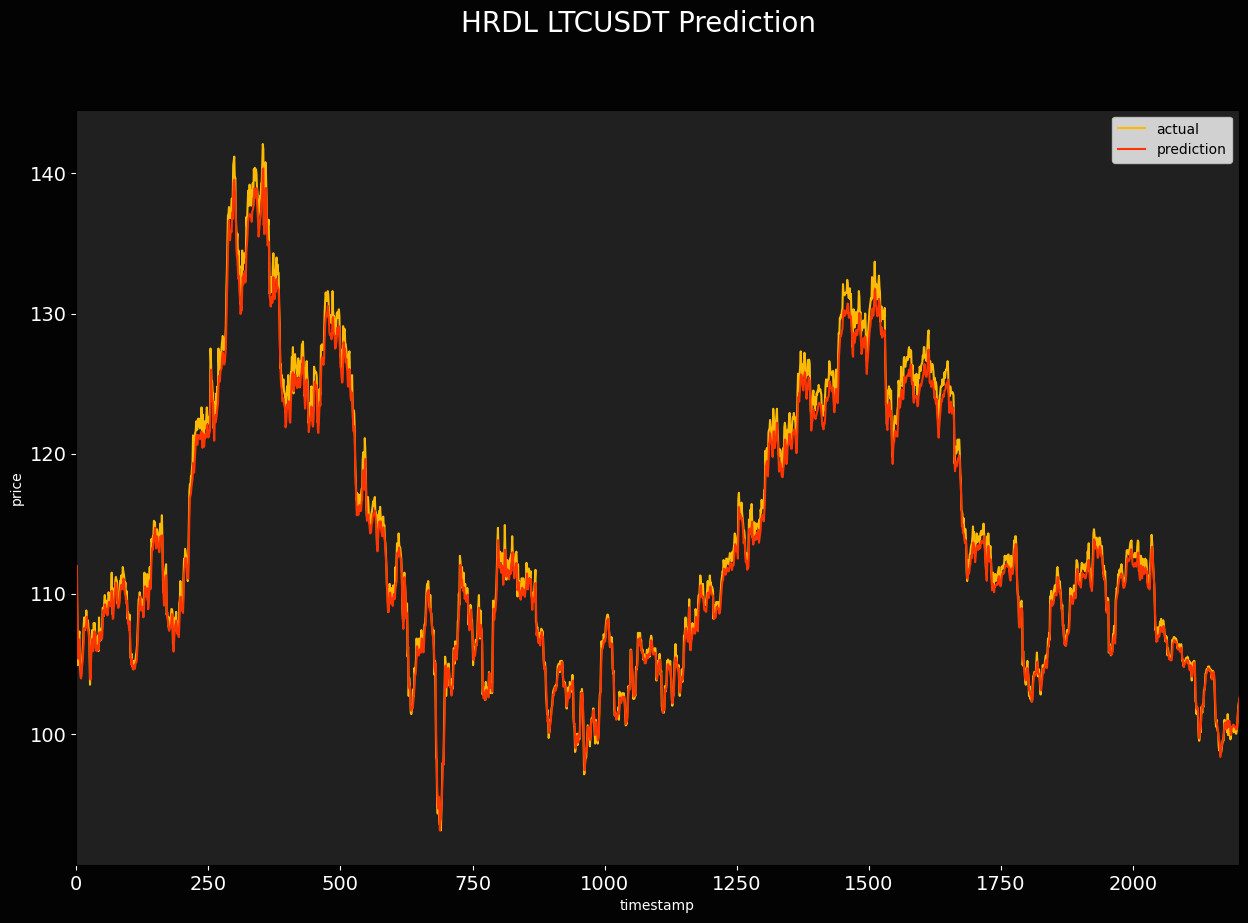

In [32]:
plt.figure(figsize = (15,10), dpi = 100, facecolor='#030303')
lstm.eval()
train_predict = lstm(testX)

data_predict = train_predict.data.numpy()
dataY_plot = testY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot[100:,1:2], c='#fcba03', label='actual')
plt.plot(data_predict[100:,1:2], c='#fc3503', label='prediction')
plt.xlabel('timestamp', color='white')
plt.ylabel('price', color='white')
ax = plt.gca()
#030303
ax.set_facecolor('#202020')
ax.tick_params(colors='white', labelsize=14)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2,
#           fancybox=True, fontsize=14)   
ax.legend()
plt.xlim([0, 2200])
plt.suptitle(f'HRDL {TRADE_PAIR} Prediction', color='white', fontsize=20)
plt.show()

## saving model

saving the model for use in the HRDL application.

In [13]:
PATH = f"../deployment/hrdlbackend/HRDL/static/models/{TRADE_PAIR}_SD.pth"
torch.save(lstm.state_dict(), PATH)